In [1]:
# install any packages not already in environment

#pip install xlrd

## 01 Data Processing

Create master dataset for rail journeys by MSOA. Validate that total number of trips stays consistent with other information published by TfL. 

In [1]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pylab import rcParams
import scipy as sp
import math
from math import sqrt
import numpy as np
import random


random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

In [2]:
# Creating a calendar to conduct left joins against

# Code adapted from: https://stackoverflow.com/questions/47150709/how-to-create-a-calendar-table-date-dimension-in-pandas

def create_date_table(start='2015-01-01', end='2023-12-31'):
   
   df = pd.DataFrame({"date": pd.date_range(start, end)})
   #df["week_day"] = df.date.dt.weekday_name
   df["day"] = df.date.dt.day
   df["weekday"] = df.date.apply(lambda x: x.strftime('%A'))
   df["month"] = df.date.dt.month
   df["week"] = df.date.apply(lambda x: x.strftime('%W'))
   #df["quarter"] = df.date.dt.quarter
   df["year"] = df.date.dt.year
   #df.insert(0, 'date_id', (df.year.astype(str) + df.month.astype(str).str.zfill(2) + df.day.astype(str).str.zfill(2)).astype(int))
   return df


In [3]:
## Read in data

# Excel/CSVs
tfljourneys = pd.read_excel('tfl-journeys-type.xls', sheet_name = 'Journeys') # useful to validate total journeys

tubetaps2020 = pd.read_csv('tubetaps2020.csv') # FOI contains Rail, Tram, Riverbus ~8M trips of 1.3B
tubetaps1517 = pd.read_csv('tubetaps1517.csv')
tubetaps1718 = pd.read_csv('tubetaps1718.csv')
tubetaps1819 = pd.read_csv('tubetaps1819.csv')
tubetaps1920 = pd.read_csv('tubetaps1920.csv')
tubetaps2021 = pd.read_csv('tubetaps2021.csv')
stnref = pd.read_csv('stn_gridref.csv') # geoemtry for stations provided by Chen

#coviddeaths = pd.read_csv('2021-04-30_llt_deathrate.csv') # Local Authority, timing is important
#covidrestrictions = pd.read_csv('restrictions_daily.csv') # Global, timing is important
#busservice2019 = pd.read_excel('bus-service-usage-19-20.xls', sheet_name = '2019')
#imd_la = pd.read_csv('Local_Authority_(Lower_Tier)_IMD_2019_(OSGB1936).csv') # IMD by Local Authority, no geometry
#geolookup = pd.read_csv('2011_OA-LSOA-MSOA-LA.csv') # Lookup table


# Shape Files
#tubestation = gpd.read_file('underground/underground.shp')
#tflstation = gpd.read_file('tfl_stations.json')
boroughs = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
#imd = gpd.read_file('IMD_2019/Indices_of_Multiple_deprivation_(IMD)_2019.shp') #LSOA, smaller than MSOA
                         
#tflstation = tflstation.to_crs('epsg:27700')
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')
#imd = imd.to_crs('epsg:27700')


# Create a calendar
calendar = create_date_table()

In [4]:
# Create a week beginning column to build 2020 trip estimates against
df = calendar

df = df.groupby(['week', 'year']).agg({'date':'min'})
df = df.reset_index()
df = df.rename({'date':'week_beg'}, axis = 1)
df_weekbeg = df[['year','week','week_beg']]

df = calendar
df = df.merge(df_weekbeg, left_on = ['year', 'week'], right_on = ['year', 'week'])

calendar = df

In [49]:
# Check data loading

#tfljourneys.head()
#tfljourneys.info()
#tubetaps2020.head()
#tubetaps2020.info()
#tubestation.head()
#stnref.head()
#tflstation.head()
#tflstation.info()
msoas.info()
#calendar.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA11CD   983 non-null    object  
 1   MSOA11NM   983 non-null    object  
 2   LAD11CD    983 non-null    object  
 3   LAD11NM    983 non-null    object  
 4   RGN11CD    983 non-null    object  
 5   RGN11NM    983 non-null    object  
 6   USUALRES   983 non-null    int64   
 7   HHOLDRES   983 non-null    int64   
 8   COMESTRES  983 non-null    int64   
 9   POPDEN     983 non-null    float64 
 10  HHOLDS     983 non-null    int64   
 11  AVHHOLDSZ  983 non-null    float64 
 12  geometry   983 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 100.0+ KB


In [6]:
# Create a singular rail dataframe

tubetaps1517 = tubetaps1517.rename({'Traffic Date': 'Travel Date'}, axis = 1)
tubetaps1718 = tubetaps1718.rename({'Traffic Date': 'Travel Date'}, axis = 1)
tubetaps2020 = tubetaps2020.rename({'Travel Location Name': 'Rail Station Name'}, axis = 1)
tubetaps2020['Travel Date'] = pd.to_datetime(tubetaps2020['Travel Date'])
tubetaps0920 = tubetaps2020[['Rail Station Name', 'Travel Date', 'Transaction Type', 'Count of Taps']]

tubetaps = tubetaps1517.append(tubetaps1718)
tubetaps = tubetaps.append(tubetaps1819)
tubetaps = tubetaps.append(tubetaps1920)
tubetaps = tubetaps.append(tubetaps2021)
tubetaps = tubetaps.append(tubetaps0920[tubetaps0920['Travel Date'] >= '8/23/2020'])

tubetaps = tubetaps.rename({'Rail Station Name': 'travel_location',
                'Travel Date': 'travel_date',
                'Transaction Type': 'transaction_type',
                'Count of Taps': 'taps'},
               axis = 1)


#tubetaps.head()

In [7]:
## TfL Journeys, for sanity checking aggregate data

# Join Period Ending against Calendar to get Monthly/Yearly columns
# Convert metrics to millions to align with Tube Taps count

tfljourneys = tfljourneys.merge(calendar, how='right', left_on="Period beginning", right_on="date")
tfljourneys['underground'] = tfljourneys['Underground journeys (m)']*1000000
tfljourneys['bus'] = tfljourneys['Bus journeys (m)']*1000000
tfljourneys['rail'] = tfljourneys['TfL Rail Journeys (m)']*1000000
tfljourneys['overground'] = tfljourneys['Overground Journeys (m)']*1000000

#tfljourneys.head()

In [8]:
# Convert stn ref to geometric dataframe
stnref = gpd.GeoDataFrame(stnref, geometry = gpd.points_from_xy(stnref.Easting, stnref.Northing))

#stnref.head()

### Data Processing for Trips Data:
 1. Create a master station reference dataframe
 2. The challenge with the tube taps data is that only 2020 has Travel Location No, which is needed to join against station reference.
 3. Therefore, all previous years of data are matched based on the station name to get the Travel Location No for past year's data.
 4. This may drive duplicates that need to be handled later.
 5. To prevent a significant loss of trips due to a lack of join on Travel Location No, we also join based on Station Name for those missing.
 6. To prevent double counting of trips for stations that have the same name but different Travel Location No, divide trips by two as station geometry is the same (Elephant & Castle, Tottenham Hale).
 
 From here, we create master dataframe of all trips based on Entry (Origin) and Exit (Destination) fields. Then, we validate the number of trips from original dataset versus merged data to see how many trips are lost. We also check how many trips are lost when we join against msoa data to capture corresponding MSOA.

In [11]:
# Create a rail station reference dataframe to get geometry against. 
# Merge station reference and calendar against daily unique tube trips
rail_station = tubetaps2020[['Travel Location No', 'Rail Station Name', 'Transport Mode']].drop_duplicates()
rail_station = rail_station[rail_station['Transport Mode']=='Rail']

# create rail ref to join against later
rail_ref = stnref.merge(rail_station, how = 'left', left_on = 'Master NLC', right_on = 'Travel Location No') 


# There are stations in the tubetaps data that cannot be joined by the Travel Location No, but have the same name
# as in the station reference dataframe. Below, we find those matching name stations from the set that do not match
# on Travel Location No

df = rail_station

missing_station = rail_ref[rail_ref['Master NLC']!=rail_ref['Travel Location No']][['Unique Station Name']]
df = df.merge(missing_station, left_on = 'Rail Station Name', right_on = 'Unique Station Name')
matching_station = list(df['Rail Station Name'])

# For stations in the tubetaps dataset that share a name but not a Travel Location No with station reference,
# we assume the name is sufficient to use the geometry from the station reference.

df = rail_ref # contains all stn ref rows and missing rail station rows

df['matching'] = df['Unique Station Name'].isin(matching_station)#['Charing Cross LU','Richmond','Upminster','Willesden Junction','Wimbledon'])

for i in range(0, len(df)):
    if df.loc[i, 'matching'] == True: # Need to figure out the if statement
        df.loc[i, 'Travel Location No'] = df.loc[i, 'Master NLC']
        df.loc[i, 'Rail Station Name'] = df.loc[i, 'Unique Station Name']
        df.loc[i, 'Transport Mode'] = 'Rail'

rail_ref = df


# Find where there are duplication rail station names, we will divide total trips by two for these stations

df = rail_ref

df = df.groupby(['Rail Station Name', 'Transport Mode'])['Unique Station Name'].agg('count')
df = pd.DataFrame(df).reset_index()
df = df[df['Unique Station Name']>1]
double_station = list(df['Rail Station Name'])

In [12]:
# Create Origin Destination trips

# First get unique set of travel stations & dates, then divide trips as origin versus destination

df = tubetaps[['travel_location', 'travel_date']].drop_duplicates()

df = df.merge(tubetaps[tubetaps['transaction_type']=='Entry'], left_on = ['travel_location', 'travel_date'], right_on = ['travel_location', 'travel_date'])
df.drop(['transaction_type'], axis=1, inplace=True)
df = df.rename({'taps': 'origin_trips'}, axis = 1)#, inplace = True)

df = df.merge(tubetaps[tubetaps['transaction_type']=='Exit'], left_on = ['travel_location', 'travel_date'], right_on = ['travel_location', 'travel_date'])
df.drop(['transaction_type'], axis=1, inplace=True)
df = df.rename({'taps': 'destination_trips'}, axis = 1)#, inplace = True)
                                                                                                                         
                                                                                                                                                                                                                                   
# Convert travel_date to date
df['travel_date'] = pd.to_datetime(df['travel_date'])


# Merge against rail reference to get geometry of stations
tubetaps_final = df.merge(rail_ref, how = 'left', left_on = 'travel_location', right_on = 'Rail Station Name')
tubetaps_final = tubetaps_final[['travel_location', 'Master NLC', 'travel_date', 'origin_trips', 'destination_trips', 'geometry']]
tubetaps_final = tubetaps_final.rename({'Master NLC': 'master_nlc'}, axis = 1)
tubetaps_final = tubetaps_final.merge(calendar, left_on = 'travel_date', right_on = 'date')


#tubetaps.info()
#tubetaps.head()
tubetaps_final.sample(6, random_state = 42)

,travel_location,master_nlc,travel_date,origin_trips,destination_trips,geometry,date,day,weekday,month,week,year,week_beg
703161,Hackney Downs,"6,867.00",2018-07-01,1456,1570,POINT (534571.401 185075.145),2018-07-01,1,Sunday,7,26,2018,2018-06-25
750171,Harringay Green Lanes,"7,401.00",2018-06-13,1231,1177,POINT (531904.522 188203.120),2018-06-13,13,Wednesday,6,24,2018,2018-06-11
647984,Hammersmith D&P,593.00,2017-07-21,39759,39882,POINT (523442.618 178517.886),2017-07-21,21,Friday,7,29,2017,2017-07-17
860192,Ruislip Manor,693.00,2018-11-06,3181,3369,POINT (510160.865 187253.617),2018-11-06,6,Tuesday,11,45,2018,2018-11-05
1063253,Turnham Green,734.00,2019-06-28,9751,10169,POINT (521255.314 178798.142),2019-06-28,28,Friday,6,25,2019,2019-06-24
42150,Cockfosters,550.00,2015-07-03,2984,2930,POINT (528185.824 196353.256),2015-07-03,3,Friday,7,26,2015,2015-06-29


In [13]:
# For loop to divide the counts for multiple stations by two. As the geometry is exactly the same, ok to divide evenly.
df = tubetaps_final
df['matching'] = df['travel_location'].isin(double_station)

for i in range(0, len(df)):
    if df.loc[i,'matching'] == True: # Need to figure out the if statement
        df.loc[i,'origin_trips'] = df.loc[i,'origin_trips']/2 
        df.loc[i,'destination_trips'] = df.loc[i,'destination_trips']/2
        
        
tubetaps_final = df

In [14]:
# Check for NA's
df = tubetaps_final
is_NaN =df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN
print(rows_with_NaN['origin_trips'].agg('sum') + rows_with_NaN['destination_trips'].agg('sum'))

734138015.0


In [15]:
# Check duplicate travel locations are dividing trips
tubetaps_final[tubetaps_final['travel_location']=='Elephant & Castle'].head()

,travel_location,master_nlc,travel_date,origin_trips,destination_trips,geometry,date,day,weekday,month,week,year,week_beg,matching
203,Elephant & Castle,570.00,2016-02-19,"15,555.00","15,197.50",POINT (531954.266 179037.451),2016-02-19,19,Friday,2,07,2016,2016-02-15,True
204,Elephant & Castle,"5,246.00",2016-02-19,"15,555.00","15,197.50",POINT (531954.266 179037.451),2016-02-19,19,Friday,2,07,2016,2016-02-15,True
915,Elephant & Castle,570.00,2016-03-13,"9,167.00","8,674.00",POINT (531954.266 179037.451),2016-03-13,13,Sunday,3,10,2016,2016-03-07,True
916,Elephant & Castle,"5,246.00",2016-03-13,"9,167.00","8,674.00",POINT (531954.266 179037.451),2016-03-13,13,Sunday,3,10,2016,2016-03-07,True
1616,Elephant & Castle,570.00,2015-11-11,"16,172.00","15,442.50",POINT (531954.266 179037.451),2015-11-11,11,Wednesday,11,45,2015,2015-11-09,True


In [16]:
# Sanity checking how many trips are lost by the join for station reference. Approximately 3B are unaccounted for.
# Less than 1B trips are lost due to Rail Transport Mode.

print(tubetaps_final['origin_trips'].agg('sum') + tubetaps_final['destination_trips'].agg('sum'))

print(tubetaps[tubetaps['transaction_type']!='PVal']['taps'].agg('sum'))

17032831576.0
17032831576.0
17012488013


In [17]:
# Convert df to GDF.

tubetaps_final = gpd.GeoDataFrame(tubetaps_final, crs = 'epsg:27700')
print(tubetaps_final['origin_trips'].agg('sum') + tubetaps_final['destination_trips'].agg('sum'))

tubetaps_final = gpd.sjoin(tubetaps_final, msoas, op = 'within') # this will return msoas polygon, spatial join against boroughs returns the same, but msoas gives us a smaller dimension
print(tubetaps_final['origin_trips'].agg('sum') + tubetaps_final['destination_trips'].agg('sum'))

#tubetaps_final.info()
#tubetaps.sample(6, random_state = 42)

17032831576.0
16003801546.0


In [18]:
tubetaps_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1149731 entries, 0 to 1296883
Data columns (total 27 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   travel_location    1149731 non-null  object        
 1   master_nlc         1149731 non-null  float64       
 2   travel_date        1149731 non-null  datetime64[ns]
 3   origin_trips       1149731 non-null  float64       
 4   destination_trips  1149731 non-null  float64       
 5   geometry           1149731 non-null  geometry      
 6   date               1149731 non-null  datetime64[ns]
 7   day                1149731 non-null  int64         
 8   weekday            1149731 non-null  object        
 9   month              1149731 non-null  int64         
 10  week               1149731 non-null  object        
 11  year               1149731 non-null  int64         
 12  week_beg           1149731 non-null  datetime64[ns]
 13  matching           

In [19]:
tubetaps_final = tubetaps_final[['travel_location',
        'master_nlc',
        'travel_date',
        'origin_trips',
        'destination_trips',
        'geometry',
        'date',
        'day',
        'weekday',
        'month',
        'week',
        'week_beg',
        'year',
        'MSOA11CD',
        'MSOA11NM',
        'LAD11CD',
        'LAD11NM']]

<AxesSubplot:xlabel='month', ylabel='total_rail'>

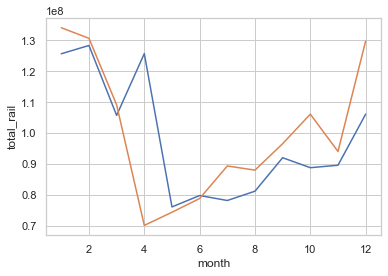

In [46]:
# Validate against Tfl Journeys trips
# For the most part, our transformed data is in the same order of magnitude as TfL journeys, the greatest difference
# is April 2019, which may be driven by double-counting of a reporting period that starts and ends in April.

tfljourneys['total_rail'] = tfljourneys['underground'] + tfljourneys['rail'] + tfljourneys['overground']

df = tfljourneys[(tfljourneys['year']>=2019)&(tfljourneys['year']<2021)].groupby(['year','month'])['total_rail'].agg('sum').reset_index()
df2 = tubetaps_final[tubetaps_final['year']>=2019].groupby(['year', 'month'])['origin_trips'].agg('sum').reset_index()
df_check = []
df_check = df.merge(df2, left_on = ['year', 'month'], right_on = ['year', 'month'])
#df_check

sns.lineplot(x = 'month', y = 'total_rail', data = df_check, ci = None, legend = True)
sns.lineplot(x = 'month', y = 'origin_trips', data = df_check, ci = None, legend = True)


In [47]:
df_check

,year,month,total_rail,origin_trips
0,2019,1,"125,762,235.01","131,632,394.00"
1,2019,2,"129,615,387.07","131,142,548.00"
2,2019,3,"134,101,950.59","144,434,034.00"
3,2019,4,"244,104,207.52","133,822,431.00"
4,2019,5,"126,145,795.91","139,784,477.00"
5,2019,6,"131,205,840.11","138,110,987.00"
6,2019,7,"120,195,763.19","144,447,238.00"
7,2019,8,"117,175,417.80","131,316,044.00"
8,2019,9,"134,923,994.62","135,467,838.00"
9,2019,10,"135,286,416.92","152,263,637.00"


In [42]:
# Export processed dataset for future analysis.
tubetaps_final.to_csv('output_data/tubetaps_final.csv',index=False)